In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import random
from PIL import Image
from tempfile import TemporaryDirectory
import shutil

cudnn.benchmark = True
plt.ion()   # interactive mode

# Importing the dataset
> I will use a dataset about animals

> dataset source: https://www.kaggle.com/datasets/likhon148/animal-data

In [2]:
%env KAGGLEHUB_CACHE=/content

env: KAGGLEHUB_CACHE=/content


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("likhon148/animal-data")

print("Path to dataset files:", path)

100%|██████████| 36.3M/36.3M [00:02<00:00, 14.3MB/s]

Extracting files...


Path to dataset files: /content/datasets/likhon148/animal-data/versions/1


In [4]:
import os

base_dir = "/content/datasets/likhon148/animal-data/versions/1/animal_data"

classes = os.listdir(base_dir)
print("classes:", classes)
print("number of classes:", len(classes))

classes: ['Dolphin', 'Kangaroo', 'Bear', 'Zebra', 'Elephant', 'Deer', 'Horse', 'Bird', 'Tiger', 'Lion', 'Cat', 'Panda', 'Dog', 'Cow', 'Giraffe']
number of classes: 15


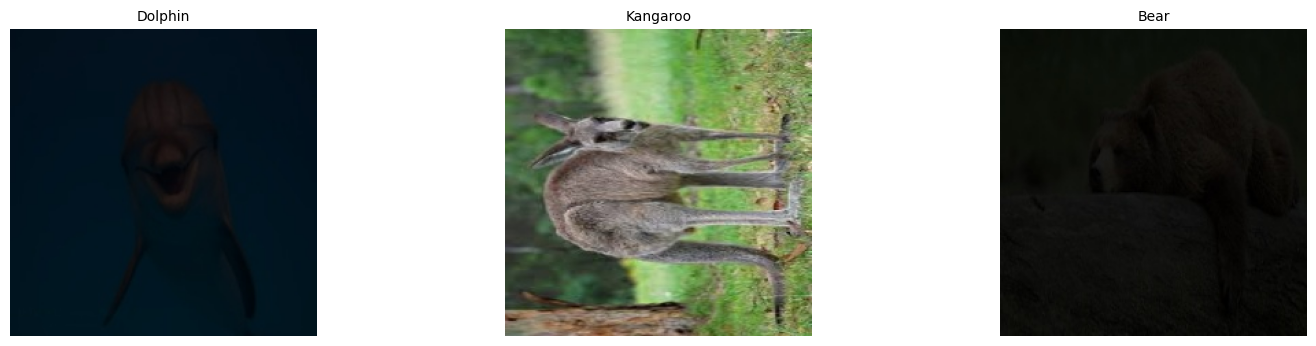

In [5]:
# check some of the data

plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes[:3]):
    folder_path = os.path.join(base_dir, cls)
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data preprocessing
> The dataset wasn't split into train and test folders, so I split them

In [6]:
# create directory for train and val
target_dir = "/content/animals-dataset"
train_dir  = os.path.join(target_dir, "train")
val_dir   = os.path.join(target_dir, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

train_ratio = 0.8

In [7]:
# split per class

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(len(images) * train_ratio)
    train_imgs = images[:split_idx]
    val_imgs  = images[split_idx:]

    # create class subfolder inside the train and val directory
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # copy image to train folder
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    # copy image to val folder
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = '/content/animals-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


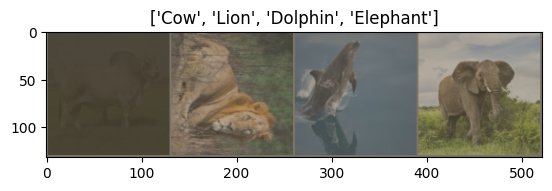

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Traning the Model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# I choose DenseNet architecture with imagenet1k weights
from torchvision.models import densenet201

dense_model = densenet201(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 179MB/s]


In [13]:
n_features = dense_model.classifier.in_features
dense_model.classifier = nn.Linear(n_features, 15)
dense_model = dense_model.to(device)

In [14]:
measure = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_model.parameters(), lr=0.00001)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
dense_model = train_model(dense_model, measure, optimizer, lr_sched, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4081 Acc: 0.3183
val Loss: 1.8374 Acc: 0.6228

Epoch 1/24
----------
train Loss: 1.6639 Acc: 0.7734
val Loss: 1.1393 Acc: 0.8481

Epoch 2/24
----------
train Loss: 1.1385 Acc: 0.8573
val Loss: 0.6542 Acc: 0.9266

Epoch 3/24
----------
train Loss: 0.8128 Acc: 0.9012
val Loss: 0.3785 Acc: 0.9367

Epoch 4/24
----------
train Loss: 0.6060 Acc: 0.9245
val Loss: 0.2496 Acc: 0.9646

Epoch 5/24
----------
train Loss: 0.4711 Acc: 0.9400
val Loss: 0.1824 Acc: 0.9570

Epoch 6/24
----------
train Loss: 0.3647 Acc: 0.9522
val Loss: 0.1174 Acc: 0.9797

Epoch 7/24
----------
train Loss: 0.3119 Acc: 0.9651
val Loss: 0.1293 Acc: 0.9747

Epoch 8/24
----------
train Loss: 0.3202 Acc: 0.9555
val Loss: 0.1192 Acc: 0.9772

Epoch 9/24
----------
train Loss: 0.3059 Acc: 0.9593
val Loss: 0.1006 Acc: 0.9823

Epoch 10/24
----------
train Loss: 0.2915 Acc: 0.9606
val Loss: 0.1118 Acc: 0.9797

Epoch 11/24
----------
train Loss: 0.2937 Acc: 0.9613
val Loss: 0.1127 Acc: 0.9772

Ep

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


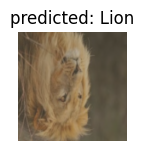

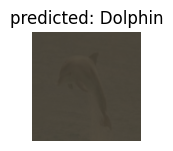

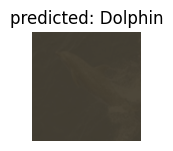

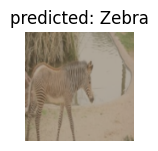

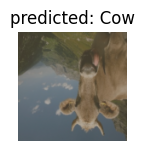

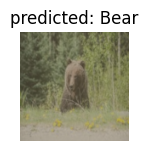

In [16]:
visualize_model(dense_model)